In [52]:
import matplotlib.pyplot as plt
import os
import seaborn as sns
import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds
import tensorflow_hub as hub

from tensorflow.keras.models import load_model
from tensorflow_examples.lite.model_maker.core.export_format import ExportFormat
from tensorflow_examples.lite.model_maker.core.task import image_preprocessing

from tflite_model_maker import image_classifier
from tflite_model_maker import ImageClassifierDataLoader
from tflite_model_maker.image_classifier import ModelSpec

In [53]:
# Retrieve the cassava plant disease dataset and splits into training, validation and test datasets

tfds_name = 'cassava'
# tfdsload function is used to load the dataset cassava as well as the splits to load 
(ds_train, ds_validation, ds_test), ds_info = tfds.load(
    name=tfds_name,
    split=['train', 'validation', 'test'],
    with_info=True,
    # loads the dataset in a format that can be used for supervised learning 
    as_supervised=True)
TFLITE_NAME_PREFIX = tfds_name

In [54]:
# Construct the list of labels and loads the training and validation datasets

label_names = ds_info.features['label'].names

train_data = ImageClassifierDataLoader(ds_train,
                                       ds_train.cardinality(),
                                       label_names)
validation_data = ImageClassifierDataLoader(ds_validation,
                                            ds_validation.cardinality(),
                                            label_names)

# This selects the name of the model to use (mobilenet v3)

model_name = 'mobilenet_v3_large_100_224' 

# this maps specific model name to the URLs for their crresponding pre-trained weights to the tensorflow hub 
map_model_name = {
    'cropnet_cassava':
        'https://tfhub.dev/google/cropnet/feature_vector/cassava_disease_V1/1',
    'cropnet_concat':
        'https://tfhub.dev/google/cropnet/feature_vector/concat/1',
    'cropnet_imagenet':
        'https://tfhub.dev/google/cropnet/feature_vector/imagenet/1',
    'mobilenet_v3_large_100_224':
        'https://tfhub.dev/google/imagenet/mobilenet_v3_large_100_224/feature_vector/5',
}

model_handle = map_model_name[model_name]

image_model_spec = ModelSpec(uri=model_handle)

In [55]:
# Constants
MODEL_WEIGHTS_FILE = 'trained_model_weights.h5'

# Check if the model weights file exists
if not os.path.exists(MODEL_WEIGHTS_FILE):
    # Build the model by training the model with the training dataset
    model = image_classifier.create(
        train_data,
        model_spec=image_model_spec,
        batch_size=16,
        learning_rate=0.03,
        epochs=1,
        shuffle=True,
        train_whole_model=True,
        validation_data=validation_data)

    # Save the trained model's weights
    model.model.save_weights(MODEL_WEIGHTS_FILE)
else:
    # Create a new model with the same architecture
    new_model = image_classifier.create(
        train_data,
        model_spec=image_model_spec,
        batch_size=16,
        learning_rate=0.03,
        epochs=0,  # Set epochs to 0 to avoid training
        shuffle=True,
        train_whole_model=True,
        validation_data=validation_data)
    
    # Load the saved model's weights
    new_model.model.load_weights(MODEL_WEIGHTS_FILE)
    model = new_model

INFO:tensorflow:Retraining the models...


INFO:tensorflow:Retraining the models...


Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 hub_keras_layer_v1v2_3 (Hub  (None, 1280)             4226432   
 KerasLayerV1V2)                                                 
                                                                 
 dropout_3 (Dropout)         (None, 1280)              0         
                                                                 
 dense_3 (Dense)             (None, 5)                 6405      
                                                                 
Total params: 4,232,837
Trainable params: 4,208,437
Non-trainable params: 24,400
_________________________________________________________________
None


In [56]:
'''
import boto3
import io
ACCESS_ID = ""
ACCESS_KEY = ""

s3 = boto3.resource('s3', region_name='us-west-2',
         aws_access_key_id=ACCESS_ID,
         aws_secret_access_key= ACCESS_KEY)
bucket = s3.Bucket('planttest123')
bucket.upload_file('/tmp/my_model.h5', object_key)
'''

'\nimport boto3\nimport io\nACCESS_ID = ""\nACCESS_KEY = ""\n\ns3 = boto3.resource(\'s3\', region_name=\'us-west-2\',\n         aws_access_key_id=ACCESS_ID,\n         aws_secret_access_key= ACCESS_KEY)\nbucket = s3.Bucket(\'planttest123\')\nbucket.upload_file(\'/tmp/my_model.h5\', object_key)\n'

In [57]:
# This is a mapping dictionary of the disease codes to names

name_map = dict(
    cmd='Mosaic Disease',
    cbb='Bacterial Blight',
    cgm='Green Mite',
    cbsd='Brown Streak Disease',
    healthy='Healthy',
    unknown='Unknown')

[(name_map[x],x) for x in label_names]

[('Bacterial Blight', 'cbb'),
 ('Brown Streak Disease', 'cbsd'),
 ('Green Mite', 'cgm'),
 ('Mosaic Disease', 'cmd'),
 ('Healthy', 'healthy')]

In [58]:
# Use the trained model to make predictions off the standard test dataset split from cassava 

test_data = ImageClassifierDataLoader(ds_test, ds_test.cardinality(),
                                      label_names)
model.predict_top_k(test_data)

[[('cmd', 0.8180576)],
 [('cmd', 0.9918162)],
 [('cmd', 0.4655323)],
 [('cmd', 0.7113053)],
 [('cmd', 0.94963914)],
 [('cmd', 0.99708253)],
 [('cmd', 0.9863239)],
 [('cmd', 0.91798)],
 [('cmd', 0.95512825)],
 [('cgm', 0.85871214)],
 [('cmd', 0.9880043)],
 [('cmd', 0.8230771)],
 [('cmd', 0.93086475)],
 [('cmd', 0.41297925)],
 [('cmd', 0.9966455)],
 [('cmd', 0.7591493)],
 [('cmd', 0.8596238)],
 [('cmd', 0.99770015)],
 [('cmd', 0.9887129)],
 [('cmd', 0.9983771)],
 [('cbsd', 0.6256269)],
 [('cmd', 0.964411)],
 [('healthy', 0.7541656)],
 [('cmd', 0.49436054)],
 [('cbsd', 0.48660985)],
 [('cmd', 0.7886236)],
 [('cmd', 0.4074834)],
 [('cgm', 0.6351042)],
 [('cmd', 0.86355704)],
 [('cbb', 0.36013153)],
 [('cmd', 0.70890313)],
 [('cmd', 0.999876)],
 [('healthy', 0.45782098)],
 [('cmd', 0.9892385)],
 [('cmd', 0.9780952)],
 [('cmd', 0.57549906)],
 [('cmd', 0.9554912)],
 [('cbsd', 0.56385386)],
 [('cmd', 0.8723233)],
 [('cmd', 0.95372146)],
 [('cmd', 0.9722934)],
 [('cmd', 0.90570295)],
 [('cmd', 

In [59]:
# Retrieve the image files from Amazon S3

import boto3
import io
# loading the the downloaded images as Numpy arrays 
import matplotlib.image as mpimg

ACCESS_ID = ""
ACCESS_KEY = ""

s3 = boto3.resource('s3', region_name='us-west-2',
         aws_access_key_id=ACCESS_ID,
         aws_secret_access_key= ACCESS_KEY)
bucket = s3.Bucket('planttest123')
# storing
images = {}
summaries = bucket.objects.all()
for f in summaries:
    bstream = io.BytesIO()
    if str(f.key).upper().endswith(".JPG") or str(f.key).upper().endswith(".JPEG"):
        bucket.Object(f.key).download_fileobj(bstream)
        images[f.key] = mpimg.imread(bstream, format="JPEG")
        print(f.key)

image (1).JPG
image (1).jpeg
image (13).JPG
image_1.JPG
image_2.JPG
test_plant.JPG
test_plant2.JPG


In [60]:
# Construct a new dataset using my image files 
v = [x for x in images.values() if x.shape[0] == 256 and x.shape[1] == 256] #list(images.values())

input_1 = np.array(v) #np.array(list(images.values())) #np.array((img1, img2))
input_2 = np.array([0]*len(v)) #np.array((0, 0))

ds_test2 = tf.data.Dataset.from_tensor_slices((input_1, input_2))

#tf.data.Dataset.from_tensor_slices([img1, img2])
test_data2 = ImageClassifierDataLoader(ds_test2, ds_test2.cardinality(),
                                      label_names)


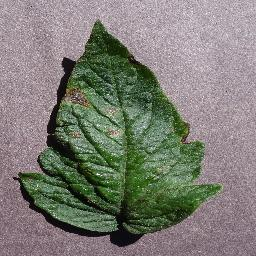

('Mosaic Disease', 0.7917193)


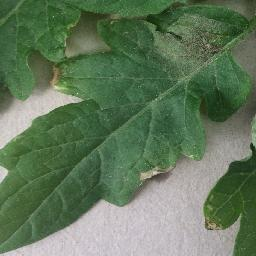

('Healthy', 0.5202116)


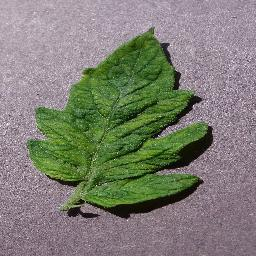

('Mosaic Disease', 0.8983873)


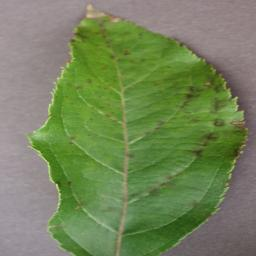

('Healthy', 0.3743832)


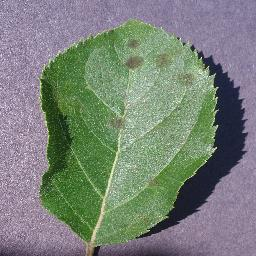

('Green Mite', 0.4059359)


In [61]:
# Show the images 
from PIL import Image as im

# Predict whether the images have disease
# Returns (label, probability)
labels = [(name_map[x[0][0]],x[0][1]) for x in model.predict_top_k(test_data2)]

i=0
for d in ds_test2:
    display(im.fromarray(d[0].numpy()))
    print(labels[i])
    i+=1

In [62]:
CESS_ID = ""
ACCESS_KEY = ""
dynamodb = boto3.resource('dynamodb', region_name='us-west-2',
         aws_access_key_id=ACCESS_ID,
         aws_secret_access_key= ACCESS_KEY)
table_name = 'Garden'
table = dynamodb.Table(table_name)
email_client = boto3.client("ses", region_name="us-west-2", 
                            aws_access_key_id=ACCESS_ID, 
                            aws_secret_access_key= ACCESS_KEY)

# Get the labels for the test data using the trained model
labels = [(name_map[x[0][0]]) for x in model.predict_top_k(test_data2)]
garden_id = 0
# Store the labels in the DynamoDB table
diseased = True
for label in labels:
    # Create an item to be inserted into the table
    if (label == "Healthy"):
        diseased = False
    key = "item" + str(i)
    i += 1
    
    item = {
        "Garden_Id": garden_id,
        "label": label,
        "diseased": diseased
#         "probability": 
    }
        
    # Insert the item into the table
    table.put_item(TableName="Garden", Item=item)
    garden_id += 0
    
    body_data = str(garden_id) + " - " + label + " detected"
    body_page = """
        <html>
        <head></head>
        <body>
        <h2>Disease Detected - """ + label + """</h2>""" + """
        <p>Found in GardenId = """ + str(garden_id) + """
        </body>
        </html> """
    if diseased:
        try:
            email_client.send_email(Source="ttsega03@gmail.com", 
                                   Destination={
                                       "ToAddresses": [
                                           "mesteddy14@gmail.com"
                                       ]
                                   }, Message={
                                       "Subject": {
                                           "Data": "Disease Detected",
                                           "Charset": "UTF-8"
                                       },
                                       "Body": {
                                           "Text": {
                                               "Data": body_data,
                                               "Charset": "UTF-8"
                                           },
                                           "Html": {
                                               "Data": body_page,
                                               "Charset": "UTF-8"
                                           }
                                       }
                                   }
                                   )
        except Exception as e:
            print(e)
    garden_id += 1
    print("done!")

ClientError: An error occurred (InvalidSignatureException) when calling the PutItem operation: The request signature we calculated does not match the signature you provided. Check your AWS Secret Access Key and signing method. Consult the service documentation for details.